# Прогнозирование оттока клиентов сети фитнес-центров «Культурист-датасаентист»

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет.

**Задача** — провести анализ и подготовить план действий по удержанию клиентов.

## Изучение данных из файла

Прежде всего импортируем необходимые нам для работы библиотеки. Делаем это в одном месте в самом начале, т.к. так удобнее и нагляднее - все библиотеки в одном месте.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Прочитаем файл gym_churn.csv и сохраним его в переменной.

In [2]:
# чтение файла с данными с сохранением в соответствующий датафрейм
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('C:/Users/au21524/Documents/03_Jupyter/YP/Projects/12_Sports_gym_churn/gym_churn.csv')

Получаем первые и последние 5 строк для изучения, а также смотрим описание и дубликаты.

In [3]:
# получение общей информации о данных в таблице
display(df.head()) # первые 5 строк
display(df.tail()) # последние 5 строк
display(df.info()) # типы даных и пропуски
print('Количество дубликатов: ',df.duplicated().sum()) # дубликаты

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
3995       1              1        1              0      1               12   
3996       0              1        0              0      1                1   
3997       1              1        1              1      1               12   
3998       0              1        1              1      1                6   
3999       1              0        1              0      0               12   

      Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
3995             0   33                      2.406023                   12.0   
3996             1   29                     68.883764                    1.0   
3997             0   28                     78.250542                   11.0   
3998             0   32                     61.912657                    5.0   
3999             1   30                    178.861814                   12.0   

      Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
3995         8                   2.284497                           2.349070   
3996         1                   1.277168                           0.292859   
3997         2                   2.786146                           2.831439   
3998         3                   1.630108                           1.596237   
3999         1                   1.101832                           1.035270   

      Churn  
3995      0  
3996      1  
3997      0  
3998      0  
3999      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Количество дубликатов:  0


Структура gym_churn.csv:

- gender — пол;
- Near_Location — проживание или работа в районе, где находится фитнес-центр;
- Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- Phone — наличие контактного телефона;
- Age — возраст;
- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).
- Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
- Group_visits — факт посещения групповых занятий;
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- Churn — факт оттока в текущем месяце.

### Вывод

В нашем распоряжении один датасет. Файл gym_churn.csv хранит в себе данные клиента за предыдущий до проверки факта оттока месяц, а также информацию на основе журнала посещений, покупок и информацию о текущем статусе абонемента клиента.

Пропущенные значения отсутствуют, все данные имеют правильный тип. Заголовки столбцов единообразны и понятны.
Дубликатов нет.

## Исследовательский анализ данных (EDA)

### Просмотр датасета

Посмотрим на датасет: отсутствующие признаки, средние значения и стандартные отклонения. Для этого применим метод describe().

In [4]:
df.describe()

gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       Avg_additional_charges_total  Month_to_end_contract     Lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       Avg_class_frequency_total  Avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             Churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Визуализируем описание датасета на ящиках с усами и посмотрим на выбросы.

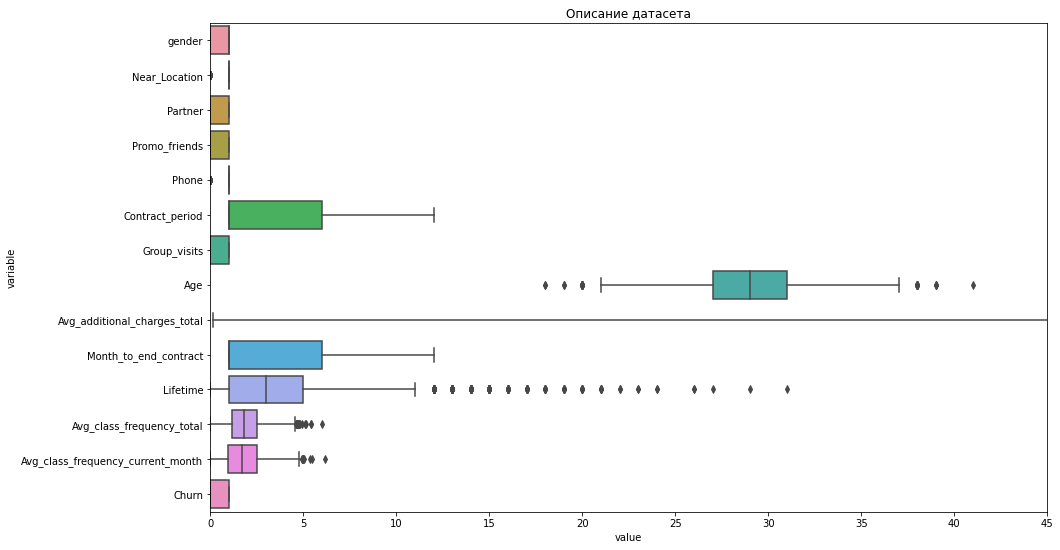

In [5]:
plt.figure(figsize=(15, 9))
plt.title('Описание датасета', loc='center')
sns.boxplot(x="value", y="variable", data=pd.melt(df))
plt.xlim([0, 45]);

Датасет состоит из 4000 строк и 14 столбцов-признаков.

7 признаков являются категориальными, преобразованными в числовые (0, 1).
7 признаков являются числовыми.

Целевая переменная находится в столбце churn и является категориальной величиной.

Пропущенные значения отсутствуют.

Пол клиентов разделен примерно поровну.
Подавляющее число клиентов живут или работают рядом.
Половина клиентов пришла из компаний - партнеров, а каждый третий по акции приведи друга.
Почти у всех есть контактный телефон.
Длительность текущего действующего абонемента: половина абонементов (50 перцентиль) на срок 1 месяц, т.е. краткосрочные.
Факт посещения групповых занятий: меньше половины клиентов хотя бы раз посещали групповые занятия.
Средний возраст клиентов клуба - 29 лет. 50% клиентов находятся в возрасте от 27 до 31 года, 25% клиентов в возрасте от 18 до 27 и 25% от 31 до 41. Старше 41 года клиентов нет.
Суммарная выручка от других услуг фитнес-центра: в среднем каждый клиент тратит около 136 у.е. Тем не менее стандартное отклонение равно 96 у.е. Соответственно разброс значений большой. 50% клиентов тратят от 69 до 210 у.е. Максимальные траты равны 553 у.е., но это исключение. Минимальное значение 0,15, т.е. каждый клиент что-то тратит.
Срок до окончания текущего действующего абонемента: у половины клиентов до конца контракта остался месяц. Это объясняется тем, что большинство контрактов и есть на месяц.
Время с момента первого обращения в фитнес-центр: в среднем этот показатель равен трем месяцам. Это говорит о том, что клиент думал какое-то время перед покупкой абонемента, либо купил сначала краткосрочный абонемент, а потом долгосрочный. Для 25% клиентов этот срок варьируется от 5 до 31 месяца. Скорее всего это те клиенты, которые уже имели долгосрочные или краткосрочные абонементы. Тем не менее рекомендуется более подробно изучить работу с первым обращением клиента, возможно какие-то клиенты очень нерешительные и долго тянули с покупкой, либо не нашли для себя выгодные условия.
Средняя частота посещений в неделю за все время с начала действия абонемента: каждый второй клиент приходит в зал 2 раза в неделю. 50% клиентов занимаются от 1 до 3 раз. Но есть и такие, кто ни разу не приходил. Лишь 25% ходят в зал более 3 раз. Максимальное значение - 6 раз.
Средняя частота посещений в неделю за предыдущий месяц: показатели текущего месяца практически равны показателям за весь период.
    
Присутствуют несколько единичные выбросы, которые можно оставить, т.к. они не окажут сильного влияния на статистики.

### Разделение на 2 группы

Посмотрим описание показателей по группам (те, кто ушел и те, кто остался). Для этого сгруппируем по столбцу Churn и применим метод describe().

In [6]:
df.groupby('Churn').describe()

gender                                              Near_Location  \
        count      mean       std  min  25%  50%  75%  max         count   
Churn                                                                      
0      2939.0  0.510037  0.499984  0.0  0.0  1.0  1.0  1.0        2939.0   
1      1061.0  0.510839  0.500118  0.0  0.0  1.0  1.0  1.0        1061.0   

                                                   Partner            \
           mean       std  min  25%  50%  75%  max   count      mean   
Churn                                                                  
0      0.873086  0.332933  0.0  1.0  1.0  1.0  1.0  2939.0  0.534195   
1      0.768143  0.422217  0.0  1.0  1.0  1.0  1.0  1061.0  0.355325   

                                         Promo_friends                      \
            std  min  25%  50%  75%  max         count      mean       std   
Churn                                                                        
0      0.498914  0.0  0.0  1.0  1.0  1.0        2939.0  0.353522  0.478144   
1      0.478837  0.0  0.0  0.0  1.0  1.0        1061.0  0.183789  0.387495   

                                 Phone                                     \
       min  25%  50%  75%  max   count      mean       std  min  25%  50%   
Churn                                                                       
0      0.0  0.0  0.0  1.0  1.0  2939.0  0.903709  0.295040  0.0  1.0  1.0   
1      0.0  0.0  0.0  0.0  1.0  1061.0  0.902922  0.296204  0.0  1.0  1.0   

                Contract_period                                           \
       75%  max           count      mean       std  min  25%  50%   75%   
Churn                                                                      
0      1.0  1.0          2939.0  5.747193  4.716942  1.0  1.0  6.0  12.0   
1      1.0  1.0          1061.0  1.728558  2.132371  1.0  1.0  1.0   1.0   

            Group_visits                                                  Age  \
        max        count      mean       std  min  25%  50%  75%  max   count   
Churn                                                                           
0      12.0       2939.0  0.464103  0.498795  0.0  0.0  0.0  1.0  1.0  2939.0   
1      12.0       1061.0  0.268615  0.443448  0.0  0.0  0.0  1.0  1.0  1061.0   

                                                          \
            mean       std   min   25%   50%   75%   max   
Churn                                                      
0      29.976523  3.009933  19.0  28.0  30.0  32.0  41.0   
1      26.989632  2.895163  18.0  25.0  27.0  29.0  38.0   

      Avg_additional_charges_total                                   \
                             count        mean        std       min   
Churn                                                                 
0                           2939.0  158.445715  99.801599  0.171862   
1                           1061.0  115.082899  77.696419  0.148205   

                                                    Month_to_end_contract  \
             25%         50%         75%        max                 count   
Churn                                                                       
0      76.920993  149.881171  224.448274  552.59074                2939.0   
1      50.629127  103.814686  165.616858  425.53522                1061.0   

                                                     Lifetime            \
           mean       std  min  25%  50%   75%   max    count      mean   
Churn                                                                     
0      5.283089  4.363522  1.0  1.0  6.0  10.0  12.0   2939.0  4.711807   
1      1.662582  1.964593  1.0  1.0  1.0   1.0  12.0   1061.0  0.990575   

                                          Avg_class_frequency_total            \
            std  min  25%  50%  75%   max                     count      mean   
Churn                                                                           
0      3.874780  0.0  2.0  4.0  6.0  31

Мы видим, что разделение примерно 1 к 3, т.е. ушел каждый третий клиент из датасета.

Разделим датасет на 2 датасета: те, кто ушел в отток и те, кто остался. Для этого воспользуемся методом query().

In [7]:
churn_yes = df.query('Churn == 1') # те, что ушли
churn_no = df.query('Churn == 0') # те, что остались

### Столбчатые гистограммы и распределения признаков

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).
Для этого напишем цикл.

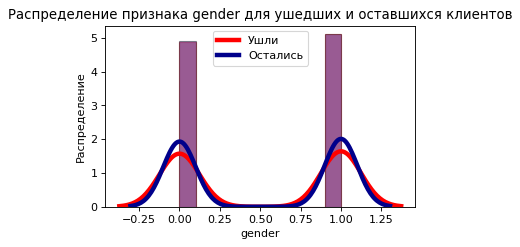

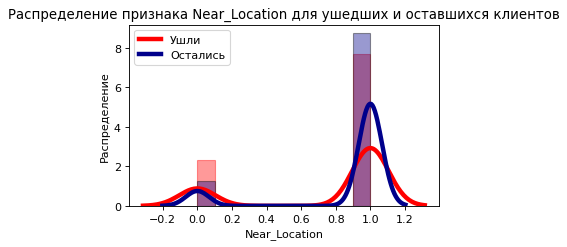

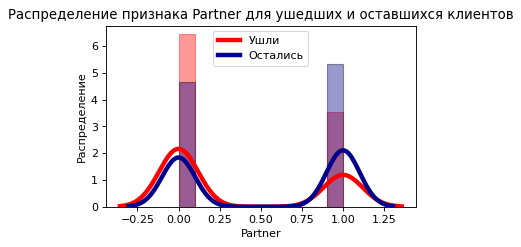

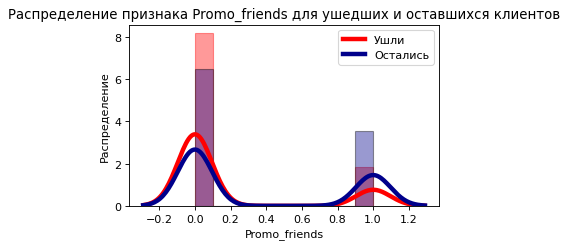

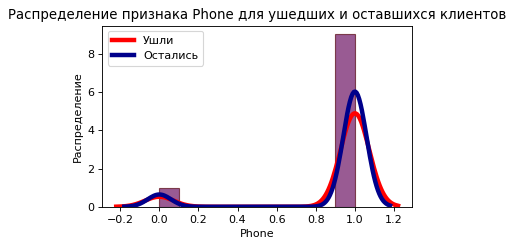

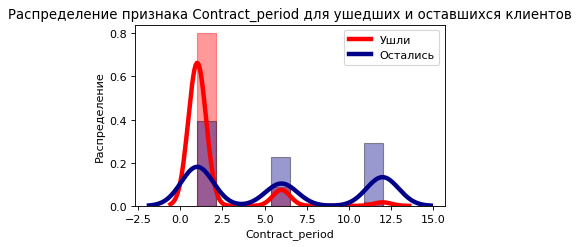

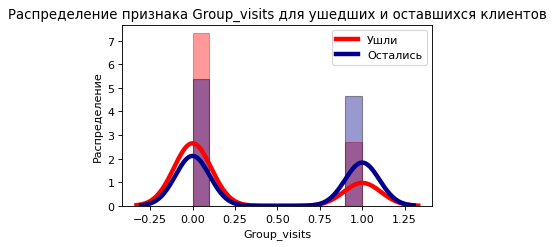

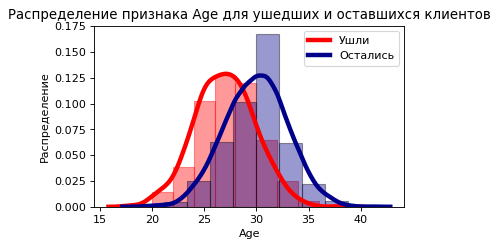

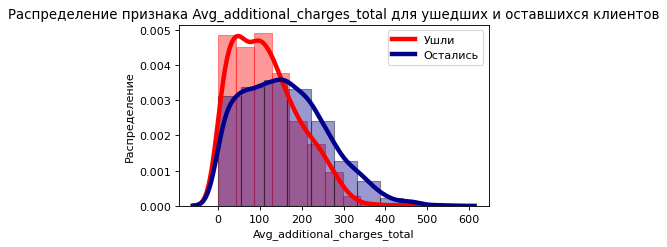

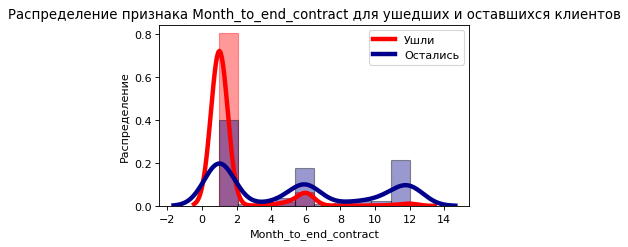

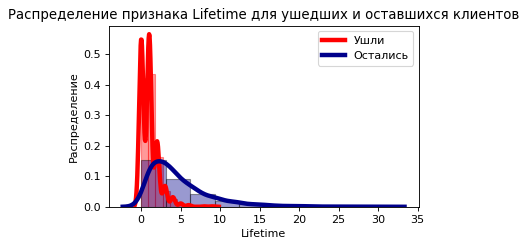

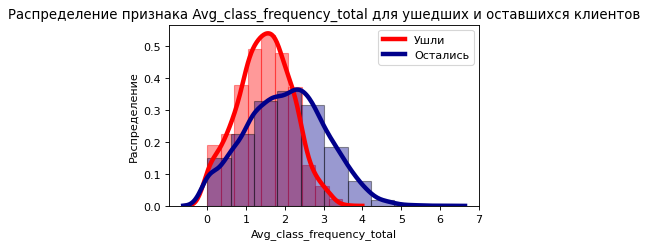

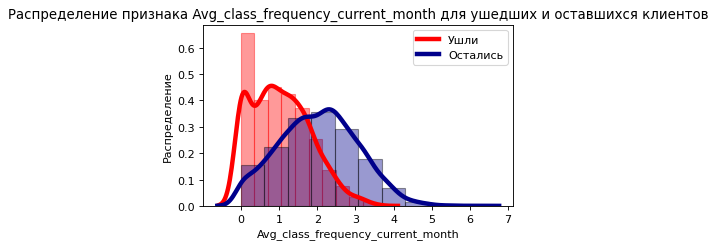

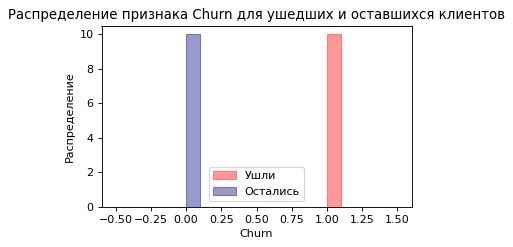

In [8]:
for column in df.columns:
        plt.figure(figsize=(5,3), dpi= 80)
        sns.distplot(churn_yes[column], hist=True, kde=True,
                     bins=int(10), color = 'red', 
                     hist_kws={'edgecolor':'red'},
                     kde_kws={'linewidth': 4})
        sns.distplot(churn_no[column], hist=True, kde=True,
                     bins=int(10), color = 'darkblue', 
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 4})
        plt.legend(['Ушли', 'Остались'], facecolor='w')
        plt.title('Распределение признака ' + str(column) + ' для ушедших и оставшихся клиентов')
        plt.ylabel('Распределение')

Как мы видим, оставшиеся в клубе клиенты чаще всего сотрудники компании-партнёра клуба, пришедшие по акции "приведи друга".
Хотя бы один раз посетившие групповые занятия чаще остаются.
Ушедшие клиенты в большинстве имеют короткие абонементы (месяц).
Возраст ушедших клиентов немного меньше, чем у оставшихся, а их суммарная выручка от других услуг фитнес-центра меньше. Ушедшие клиенты уходят практически в самом начале после первого обращения в фитнес-центр.

Чем чаще клиент ходит в зал, тем меньше вероятность, что он перестанет ходить.

### Матрица корреляций

Построим матрицу корреляций и отобразим ее на тепловой карте.

gender  Near_Location   Partner  \
gender                             1.000000       0.006699 -0.010463   
Near_Location                      0.006699       1.000000 -0.005119   
Partner                           -0.010463      -0.005119  1.000000   
Promo_friends                     -0.005033       0.210964  0.451960   
Phone                             -0.008542      -0.015763  0.009970   
Contract_period                    0.000502       0.150233  0.306166   
Group_visits                       0.017879       0.154728  0.022710   
Age                                0.013807       0.058358  0.047480   
Avg_additional_charges_total      -0.009334       0.040761  0.022941   
Month_to_end_contract             -0.001281       0.143961  0.294632   
Lifetime                           0.013579       0.070921  0.061229   
Avg_class_frequency_total          0.014620       0.043127  0.024938   
Avg_class_frequency_current_month  0.009156       0.062664  0.045561   
Churn                              0.000708      -0.128098 -0.157986   

                                   Promo_friends     Phone  Contract_period  \
gender                                 -0.005033 -0.008542         0.000502   
Near_Location                           0.210964 -0.015763         0.150233   
Partner                                 0.451960  0.009970         0.306166   
Promo_friends                           1.000000  0.001982         0.244552   
Phone                                   0.001982  1.000000        -0.006893   
Contract_period                         0.244552 -0.006893         1.000000   
Group_visits                            0.120170 -0.010099         0.169991   
Age                                     0.050113 -0.011403         0.138249   
Avg_additional_charges_total            0.036898  0.009279         0.111445   
Month_to_end_contract                   0.239553 -0.011196         0.973064   
Lifetime                                0.072721 -0.018801         0.170725   
Avg_class_frequency_total               0.028063  0.008340         0.096211   
Avg_class_frequency_current_month       0.053768  0.013375         0.159407   
Churn                                  -0.162233 -0.001177        -0.389984   

                                   Group_visits       Age  \
gender                                 0.017879  0.013807   
Near_Location                          0.154728  0.058358   
Partner                                0.022710  0.047480   
Promo_friends                          0.120170  0.050113   
Phone                                 -0.010099 -0.011403   
Contract_period                        0.169991  0.138249   
Group_visits                           1.000000  0.080934   
Age                                    0.080934  1.000000   
Avg_additional_charges_total           0.032079  0.080240   
Month_to_end_contract                  0.163703  0.134511   
Lifetime                               0.075853  0.164693   
Avg_class_frequency_total              0.056695  0.119953   
Avg_class_frequency_current_month      0.075923  0.183095   
Churn                                 -0.175325 -0.404735   

                                   Avg_additional_charges_total  \
gender                                                -0.009334   
Near_Location                                          0.040761   
Partner                                                0.022941   
Promo_friends                                          0.036898   
Phone                                                  0.009279   
Contract_period                                        0.111445   
Group_visits                                           0.032079   
Age                                                    0.080240   
Avg_additional_charges_total                           1.000000   
Month_to_end_contract                                  0.113958   
Lifetime                                               0.079028   
Avg_class_frequency_total                         

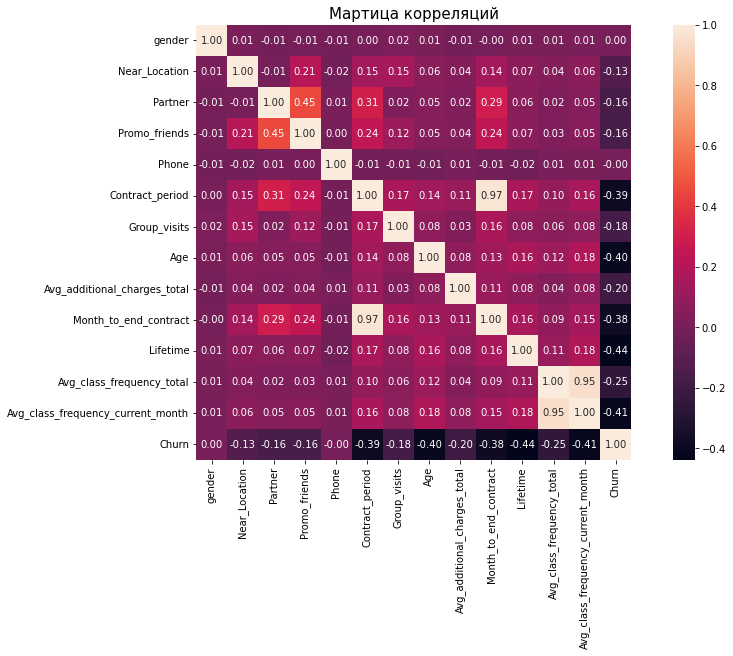

In [9]:
display(df.corr()) # корреляция вне зависимости от факта оттока
plt.figure(figsize = (15,8))
plt.title("Мартица корреляций", fontsize =15)
sns.heatmap(df.corr(), annot=True, square=True, fmt='.2f');

Больше всего между собой коррелируют длительность текущего действующего абонемента и срок до окончания текущего действующего абонемента, а также средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц.

Относительно высокая корреляция наблюдается между фактом первоначальной записи в рамках акции «приведи друга» и тем, что это сотрудник компании-партнёра клуба.

Построим тепловые карты матрицы корреляции отдельно для ушедших и оставшихся клиентов.

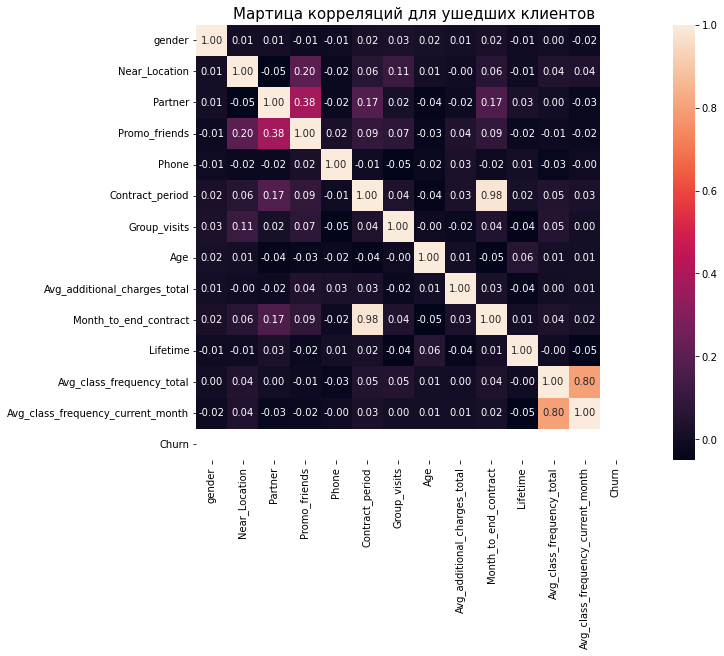

In [10]:
plt.figure(figsize = (15,8))
plt.title("Мартица корреляций для ушедших клиентов", fontsize =15)
sns.heatmap(churn_yes.corr(), annot=True, square=True, fmt='.2f'); # тепловая карта для ушедших клиентов

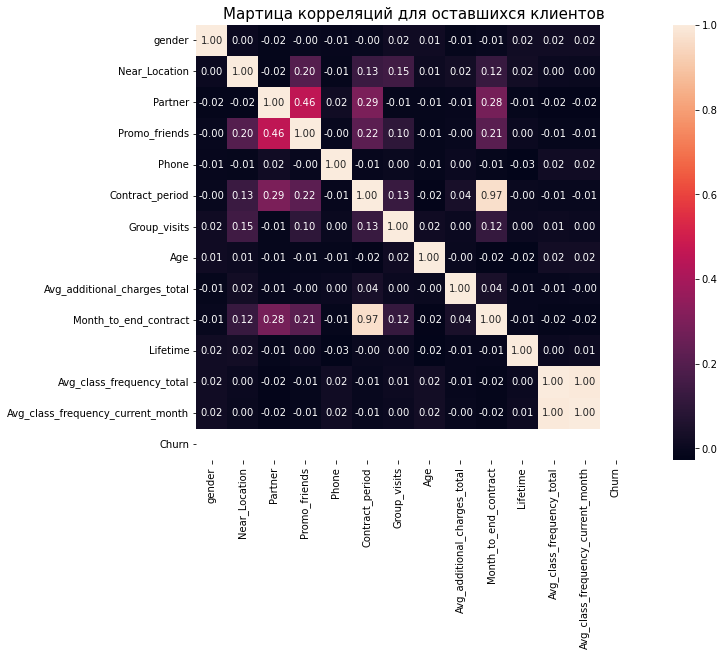

In [11]:
plt.figure(figsize = (15,8))
plt.title("Мартица корреляций для оставшихся клиентов", fontsize =15)
sns.heatmap(churn_no.corr(), annot=True, square=True, fmt='.2f'); # тепловая карта для оставшихся клиентов

Посмотрим на диаграмме рассеяния как соотносятся признаки мужду собой.

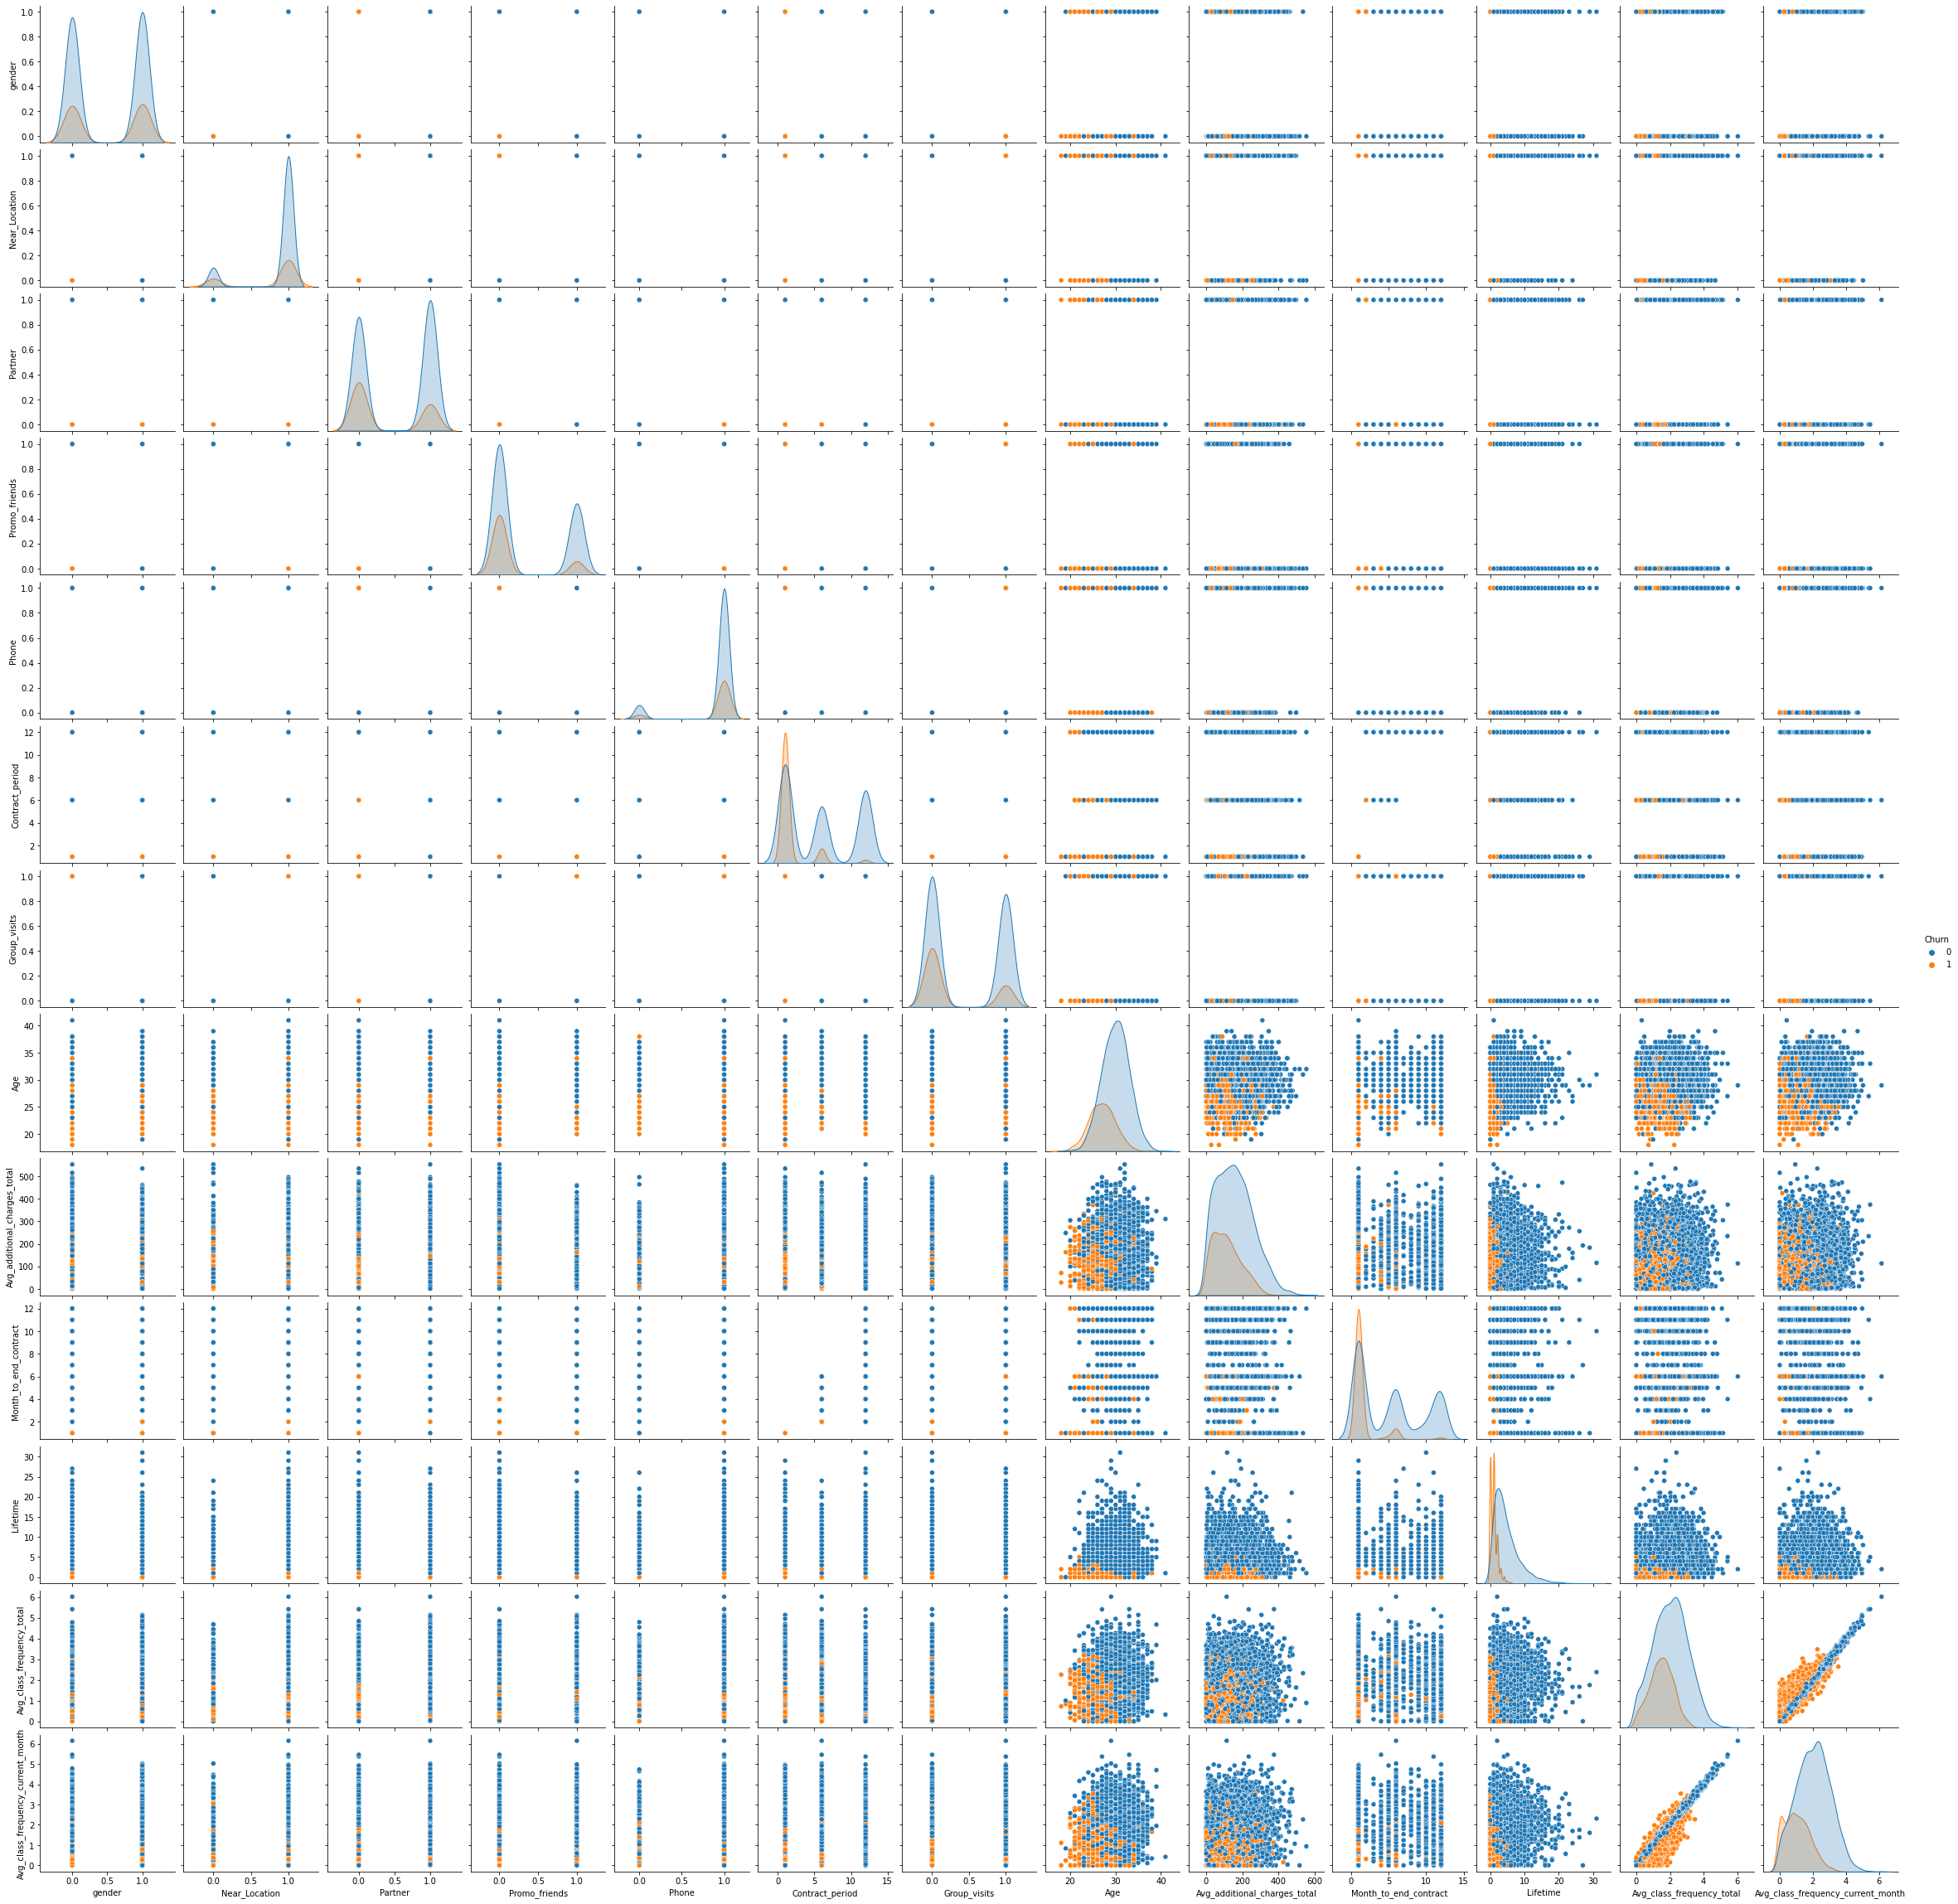

In [12]:
sns.pairplot(df, hue="Churn");

Посмотрим более подробно на признаки с высокой корреляцией.

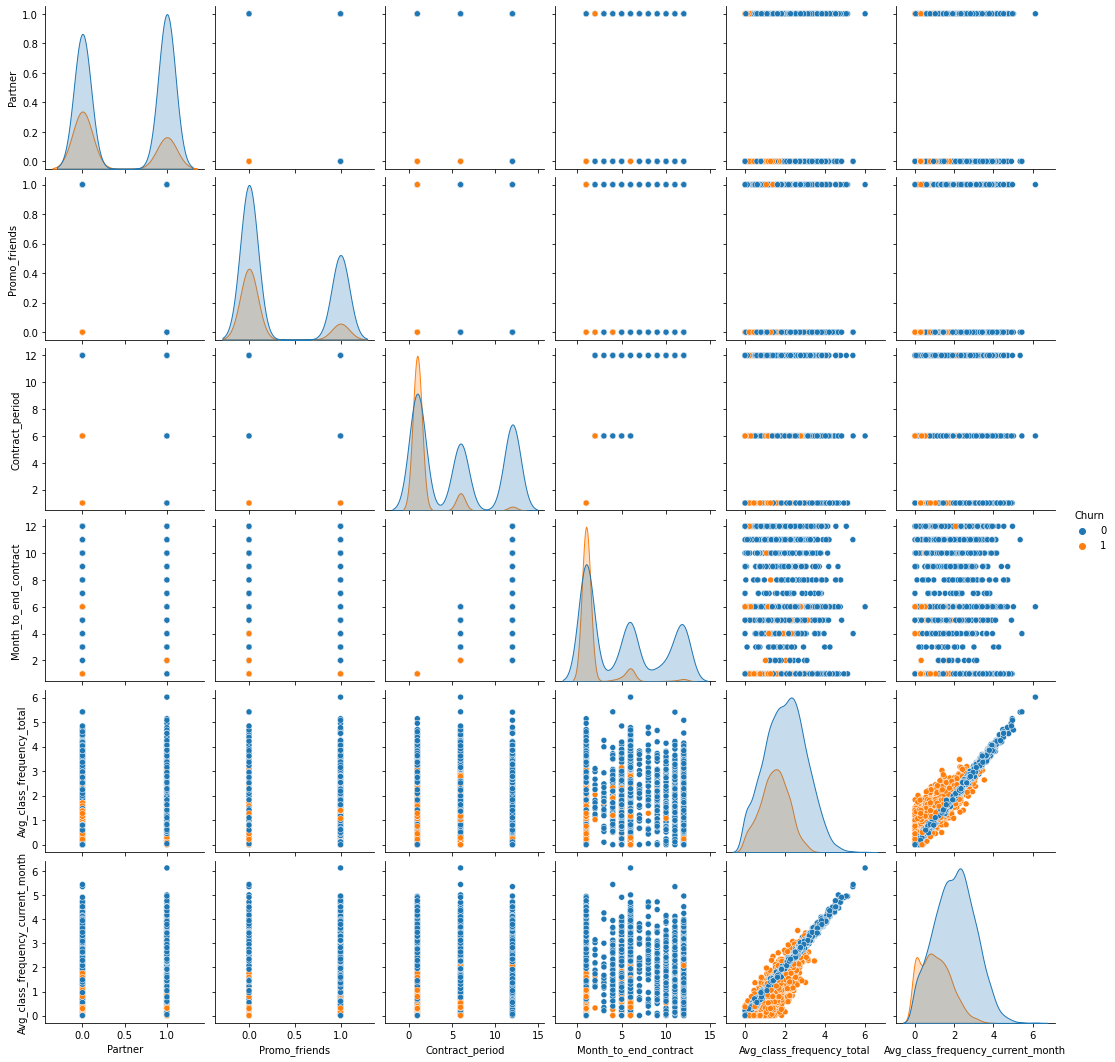

In [13]:
sns.pairplot(df, vars=['Partner', 'Promo_friends', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month'], hue="Churn");

### Вывод

Датасет состоит из 4000 строк и 14 столбцов-признаков.

7 признаков являются категориальными, преобразованными в числовые (0, 1).
7 признаков являются числовыми.

Целевая переменная находится в столбце churn и является категориальной величиной.

Пропущенные значения отсутствуют.

Разделение датасета примерно 1 к 3, т.е. ушел каждый третий клиент из датасета.

Оставшиеся в клубе клиенты чаще всего сотрудники компании-партнёра клуба, пришедшие по акции "приведи друга". Хотя бы один раз посетившие групповые занятия чаще остаются. Ушедшие клиенты в большинстве имеют короткие абонементы (месяц). Возраст ушедших клиентов немного меньше, чем у оставшихся, а их суммарная выручка от других услуг фитнес-центра меньше. Ушедшие клиенты уходят практически в самом начале после первого обращения в фитнес-центр.

Чем чаще клиент ходит в зал, тем меньше вероятность, что он перестанет ходить.

Больше всего между собой коррелируют длительность текущего действующего абонемента и срок до окончания текущего действующего абонемента, а также средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц. Относительно высокая корреляция наблюдается между фактом первоначальной записи в рамках акции «приведи друга» и тем, что это сотрудник компании-партнёра клуба. У оставшихся клиентов корреляция по этим признакам выше.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

### Разделение выборки

Разделим данные на признаки и целевую переменную.

In [14]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']

Разобьем данные на обучающую и валидационную выборку функцией train_test_split().

In [15]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель на train-выборке двумя способами:
- логистической регрессией
- случайным лесом

### Логистическая регрессия

Применим алгоритм для решения задачи бинарной классификации. Модель сможет не просто прогнозировать финальное значение класса для клиента, а ещё и оценивать вероятность рассматриваемого события.

In [16]:
# зададим алгоритм для нашей модели
lr = LogisticRegression(solver='liblinear', random_state = 0)

# обучим модель
lr.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr.predict(X_test)
lr_probabilities = lr.predict_proba(X_test)[:, 1]

### Случайный лес

In [17]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf.predict(X_test) # Ваш код здесь
rf_probabilities = rf.predict_proba(X_test)[:, 1]

### Метрики accuracy, precision и recall

Оценим метрики accuracy, precision и recall, F1 и ROC_AUC для обеих моделей на валидационной выборке. Сравним по ним модели. 

In [18]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [19]:
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
	F1: 0.85
	ROC_AUC: 0.97


In [20]:
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82
	F1: 0.83
	ROC_AUC: 0.97


### Вывод

Мы разделили данные на признаки и целевую переменную, на обучающую и валидационную выборку.

Затем обучили модель на train-выборке двумя способами: логистической регрессией и случайным лесом.

В конце оценили метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

И та и другая модель показывают хороший результат.

Но результат модели логистической регрессии чуть лучше.

## Кластеризация клиентов

Проведем кластеризацию объектов (клиентов) для того, чтобы уменьшить наш датасет.

Кластеризация поможет нам выделить разные сегменты клиентов и предложить каждому сегменту подходящий вариант продукта, чтобы предотвратить их отток.

### Стандартизация данных

Сначала приведем признаки к единому масштабу методом стандартизации.

Стандартизация приведёт значения признаков к виду стандартного нормального распределения: значения будут центрированы относительно 0, а средний разброс данных составит 1. Стандартизируем данные:

In [21]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

На выходе получим преобразованные таблицы объект-признак для обучающего и валидационного набора. И уже их будем применять для обучения и прогнозирования.

### Матрица расстояний

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

Для этого передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage(). Чтобы диаграмма получилась показательной, лучше передать параметру method значение 'ward'.

In [22]:
linked = linkage(X_sc, method = 'ward')

В переменной linked сохранена таблица «связок» между объектами. Визуализируем ее как дендрограмму:

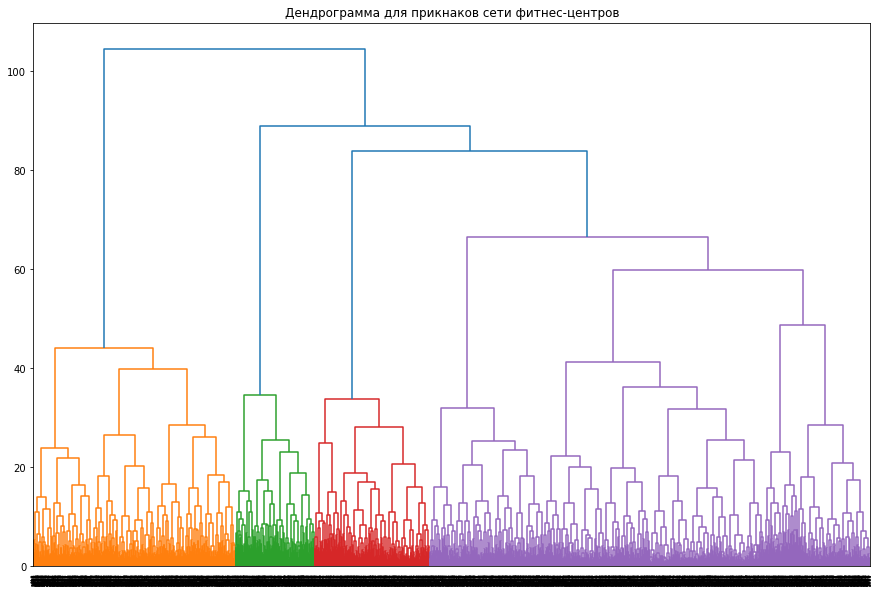

In [23]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма для прикнаков сети фитнес-центров')
plt.show();

Оптимальное число кластеров 5, если взять меньше - они будут слишком крупными, если меньше - то слишком мелкими и детальными.

### Модель кластеризации на основании алгоритма K-Means

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять n=5.

In [24]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels

### Средние значения признаков для кластеров

In [25]:
# посмотрим количество клиентов по кластерам
df.groupby('cluster')['Churn'].count()

cluster
0    1010
1     385
2     505
3    1262
4     838
Name: Churn, dtype: int64

Посмотрим на средние значения признаков для кластеров. Применим методы groupby() и mean().

In [26]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster').mean()

gender  Near_Location   Partner  Promo_friends     Phone  \
cluster                                                               
0        0.502970       0.959406  0.783168       0.574257  1.000000   
1        0.522078       0.862338  0.470130       0.306494  0.000000   
2        0.495050       0.000000  0.463366       0.079208  1.000000   
3        0.485737       1.000000  0.350238       0.240095  1.000000   
4        0.559666       0.976134  0.356802       0.230310  0.998807   

         Contract_period  Group_visits        Age  \
cluster                                             
0              10.889109      0.542574  29.982178   
1               4.787013      0.425974  29.301299   
2               2.352475      0.215842  28.477228   
3               1.948494      0.341521  28.167987   
4               2.669451      0.473747  30.125298   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster                                                                  
0                          160.761016               9.954455  4.736634   
1                          143.957664               4.475325  3.924675   
2                          135.457501               2.198020  2.809901   
3                          131.622204               1.856577  2.440571   
4                          161.657905               2.459427  4.898568   

         Avg_class_frequency_total  Avg_class_frequency_current_month  \
cluster                                                                 
0                         1.982055                           1.974789   
1                         1.847220                           1.716369   
2                         1.660461                           1.477324   
3                         1.247634                           1.012983   
4                         2.852002                           2.850161   

            Churn  
cluster            
0        0.027723  
1        0.267532  
2        0.443564  
3        0.514263  
4        0.068019

Сразу бросается в глаза кластер номер 0. Его отличительные особенности:
- средний показатель по факту оттока в текущем месяце минимален (0,03)
- большая часть - это сотрудники компании-партнёра клуба
- длительность текущего действующего абонемента в среднем 11 месяцев (т.е. большинство абонементов - годовые)
- чуть больше половины посещают групповые занятия
- суммарная выручка от других услуг фитнес-центра в среднем выше, чем в других кластерах (кроме 4)
- срок до окончания текущего действующего абонемента в среднем 10 месяцев (т.е. клиенты в начале своего абонемента)
- посещают клуб около 2 раз в неделю (как до текущего месяца, так и в текущем месяце)

Противоположные ему кластер номер 3:
- средний показатель по факту оттока в текущем месяце максимален (0,51)
- проживают в районе расположения клуба
- длительность текущего действующего абонемента в среднем 2 месяца (краткосрочный абонемент, приобретаемый для тестирования услуг клуба, на период отпуска и т.п.)
- лишь треть из клиентов ходит на групповые занятия
- суммарная выручка от других услуг фитнес-центра в среднем ниже, чем в других кластерах
- срок до окончания текущего действующего абонемента в среднем 2 месяца (т.е. клиенты в начале своего абонемента)
- посещают клуб раз в неделю, и частота посещений сокращается

Кластер номер 1 выделяется отсутствием номеров телефона.
    
Кластер номер 2 имеет второй по величине уровень оттока: проживает/работает не рядом с фитнес-клубом и имеет самый низкий показатель прихода по акции приведи друга. Представители этого класса реже других хотя бы один раз ходят на групповые занятия.
    
Кластер номер 4: возраст представителей этого кластера чуть выше, чем других и клиенты этого кластера тратят на другие услуги клуба больше других кластеров (незначительно больше по сравнению с 0 кластером). Яркой отличительной чертой кластера является средняя частота посещений в неделю. Данный показатель равен почти 3. Так же данный кластер имеет маленькую долю оттока (0,07). 

### Распределения признаков для кластеров

Построим распределения признаков для кластеров. 

In [27]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

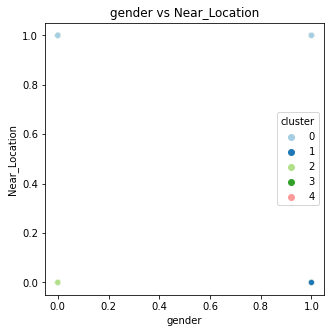

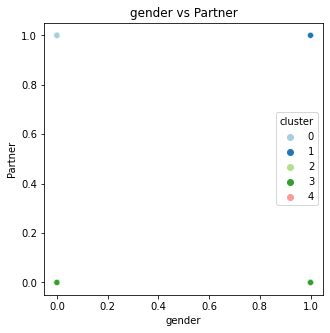

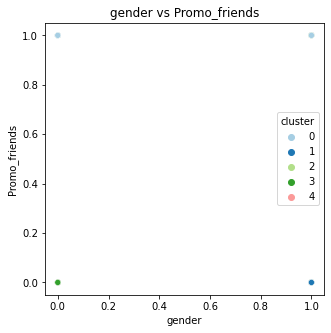

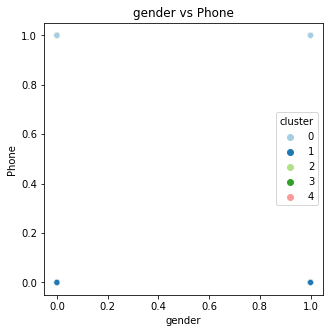

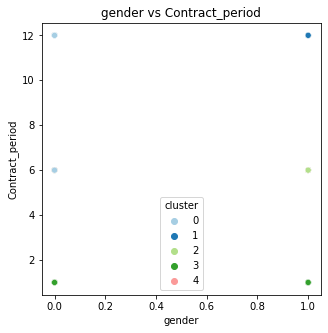

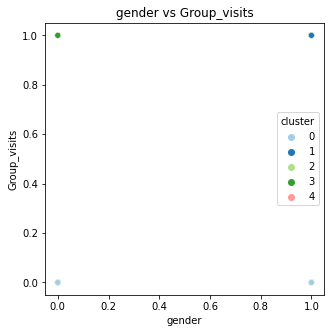

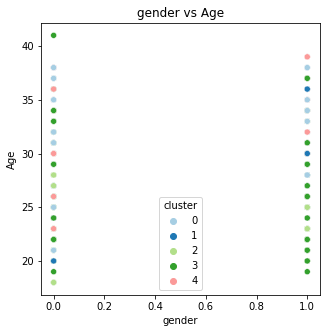

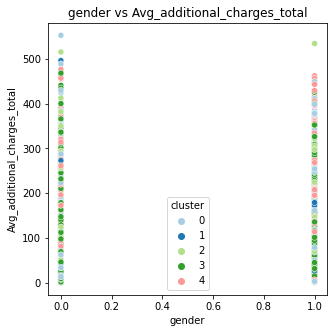

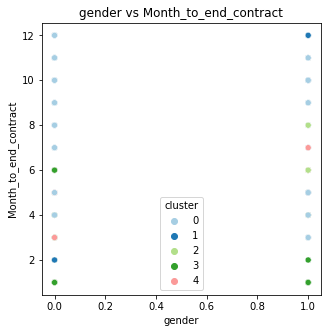

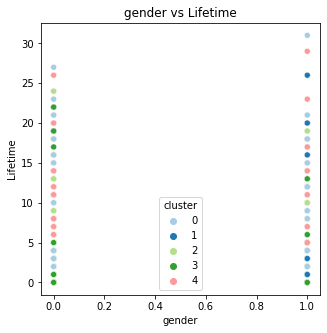

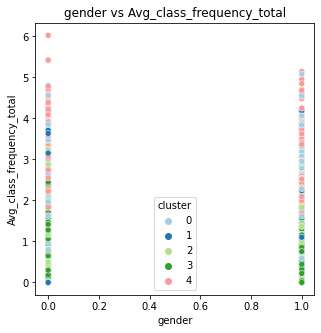

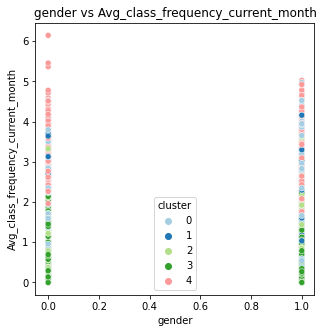

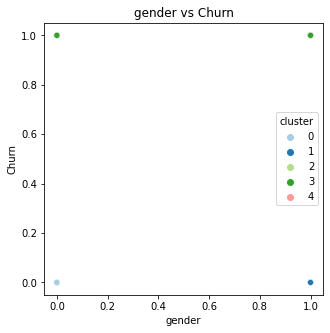

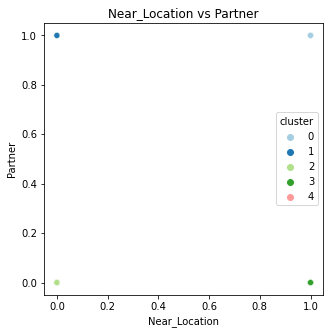

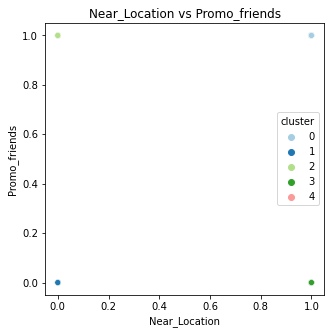

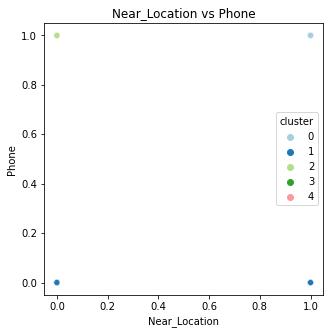

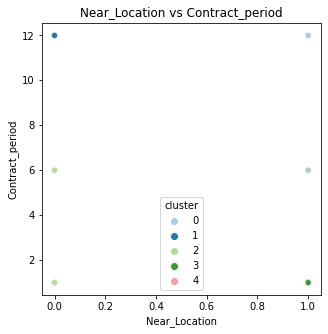

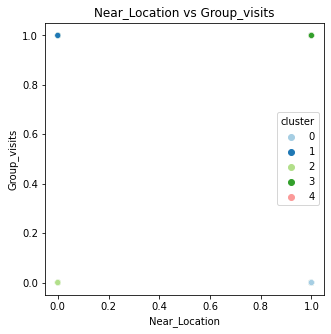

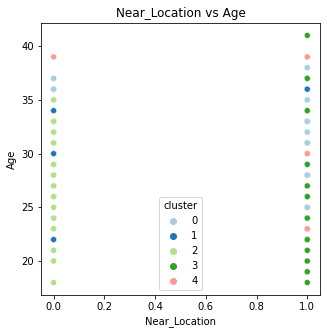

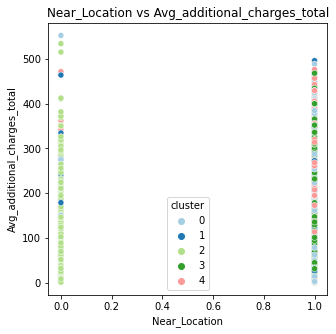

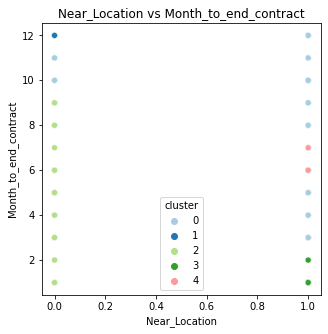

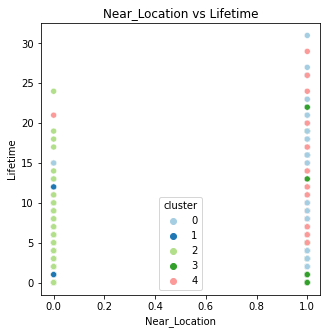

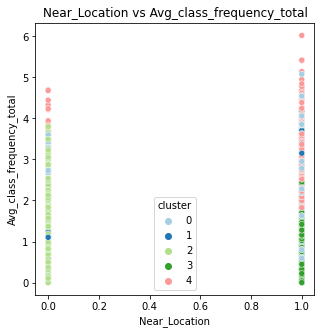

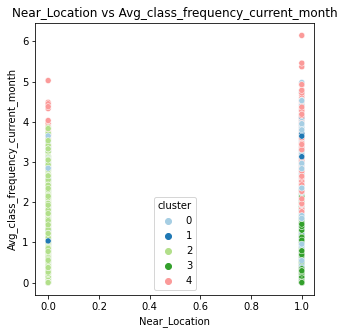

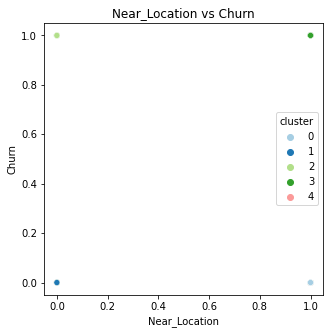

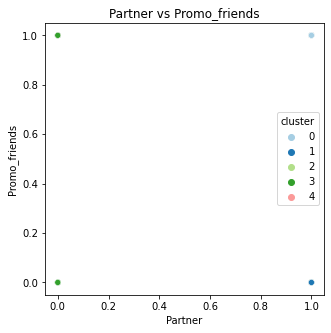

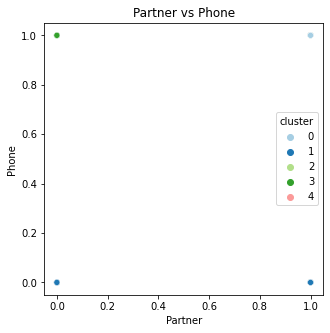

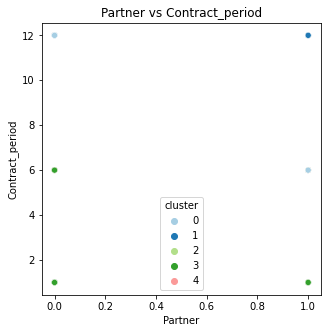

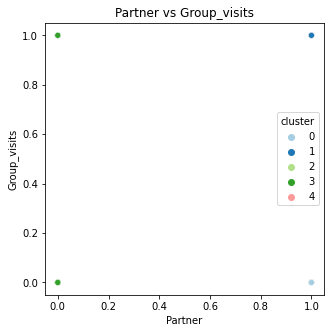

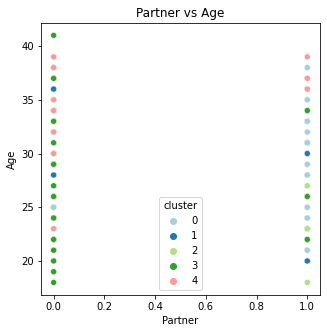

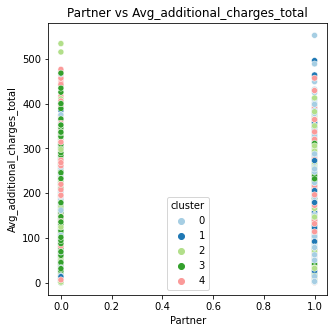

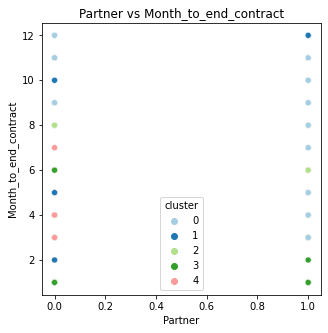

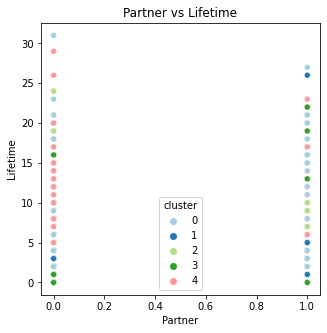

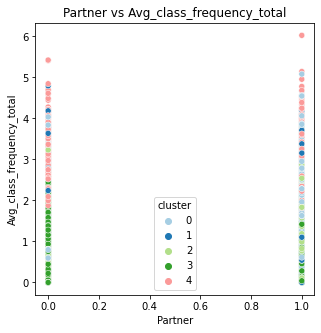

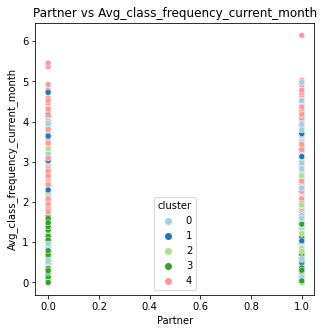

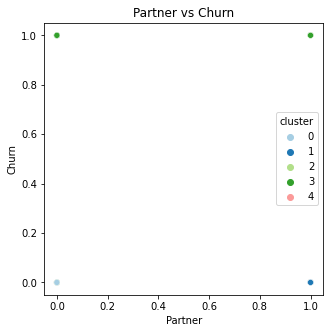

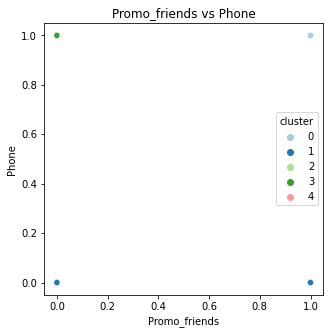

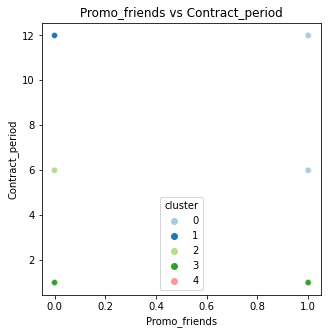

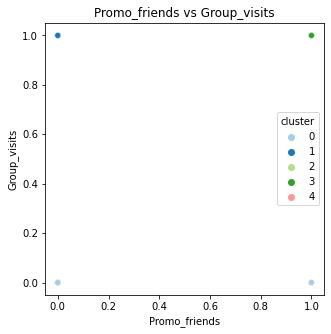

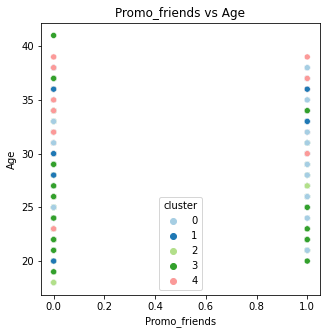

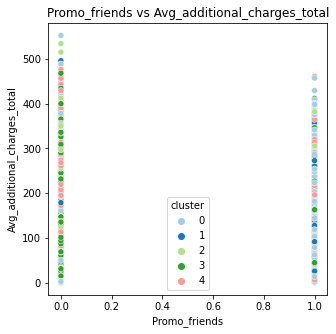

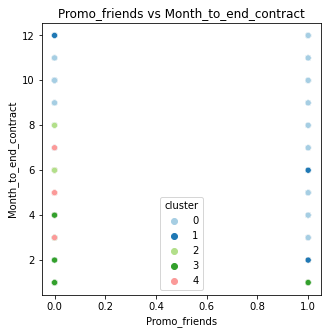

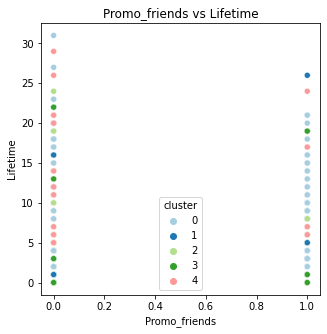

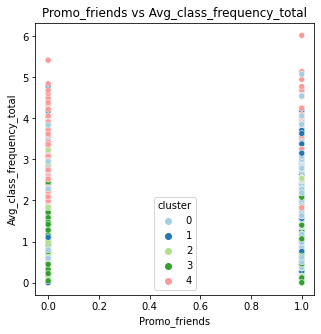

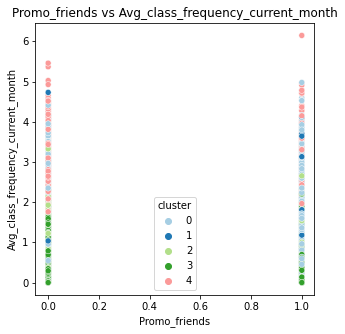

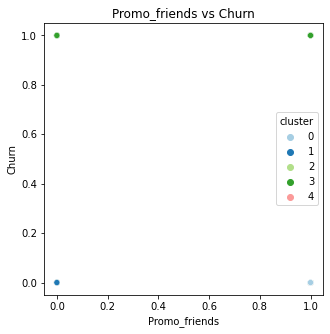

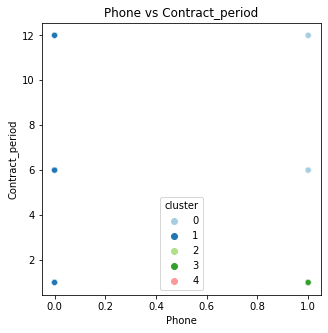

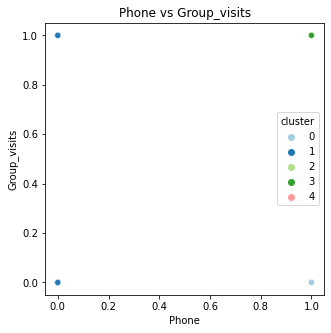

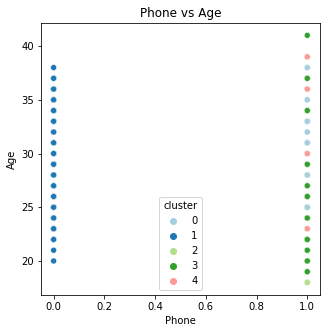

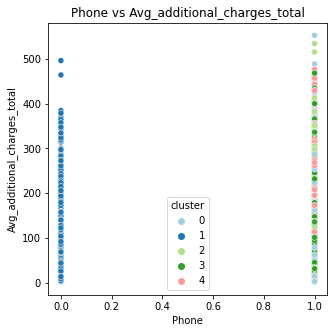

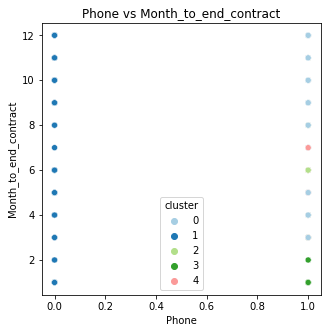

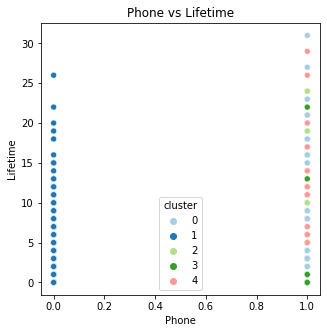

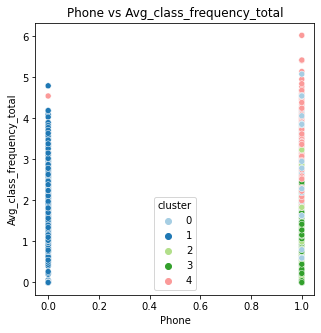

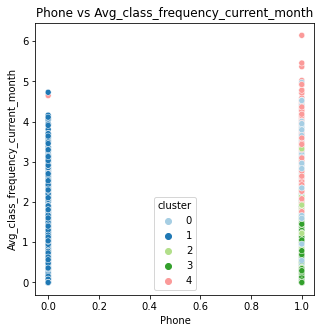

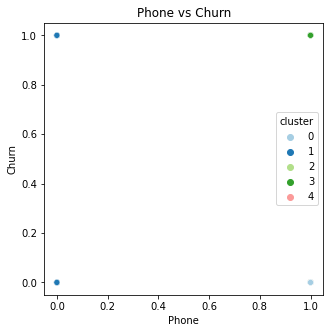

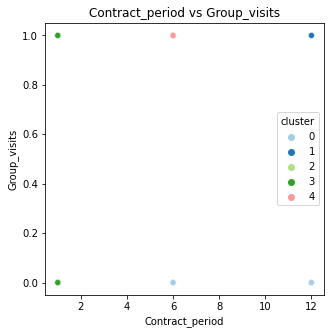

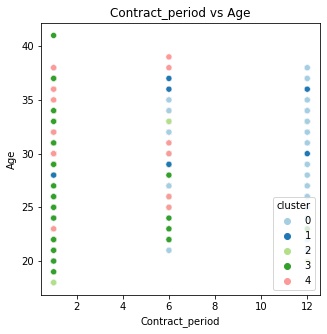

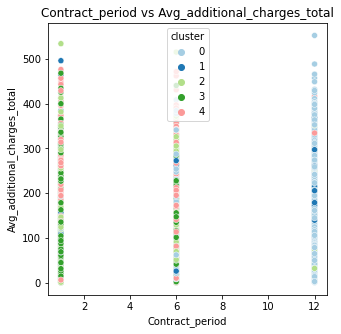

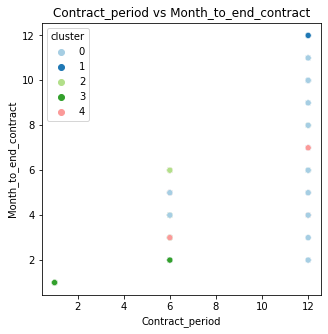

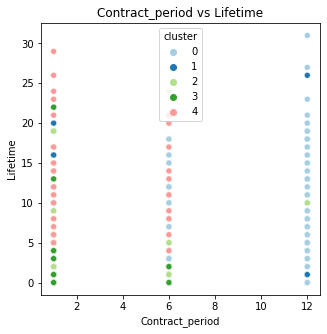

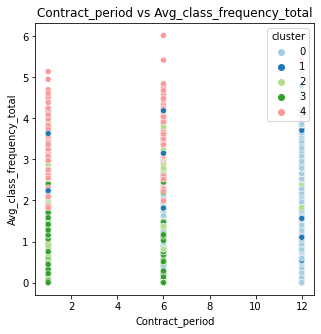

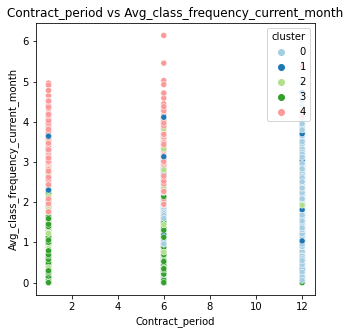

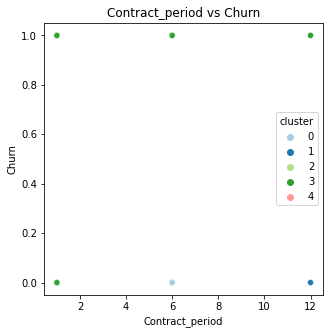

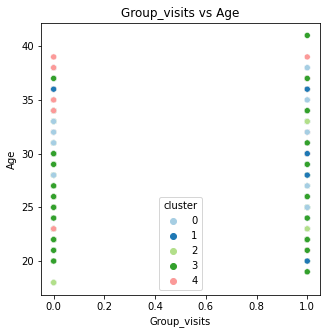

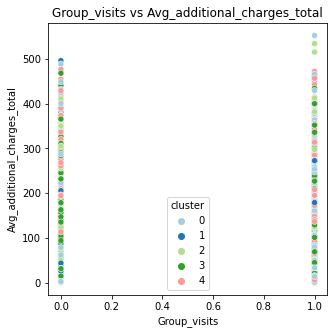

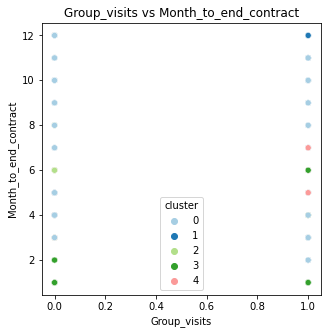

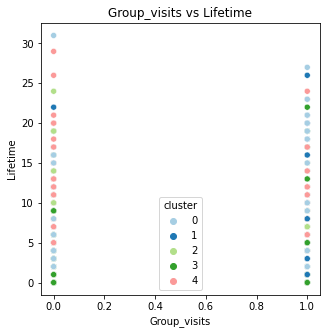

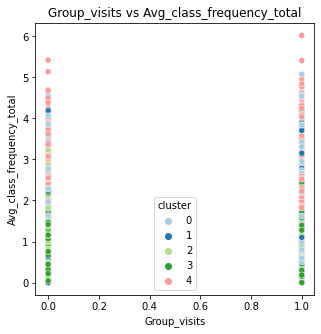

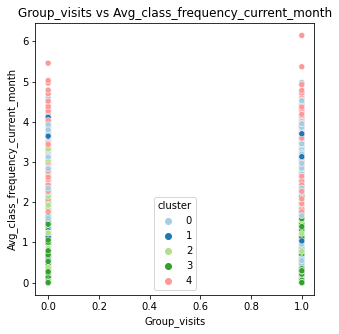

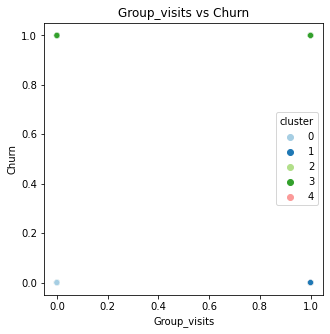

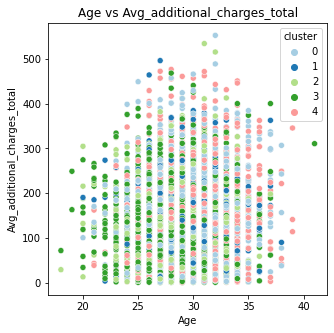

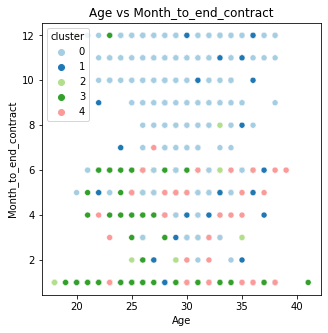

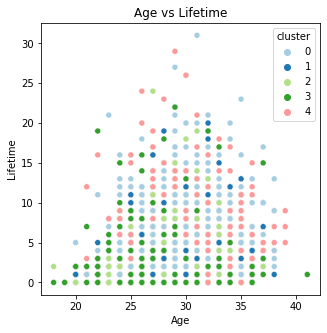

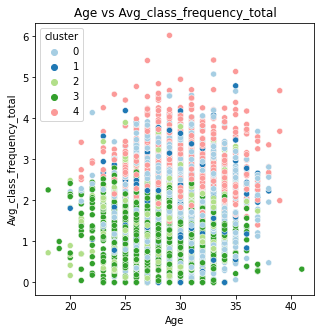

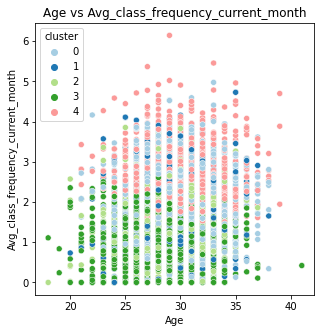

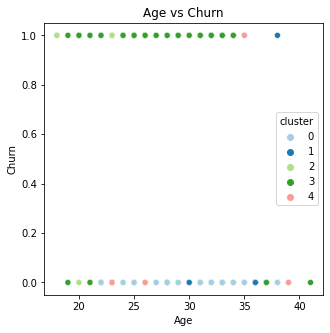

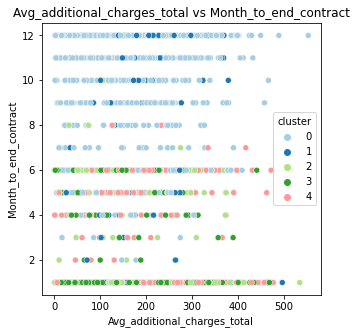

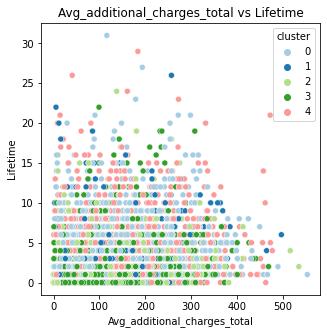

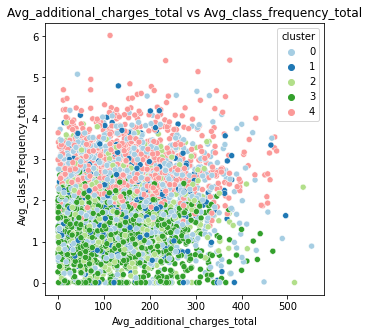

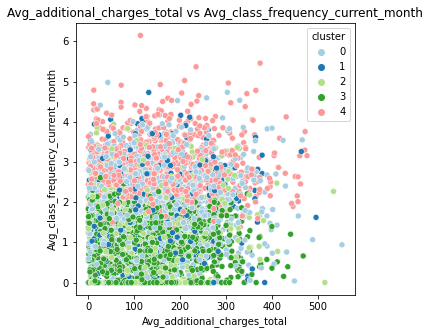

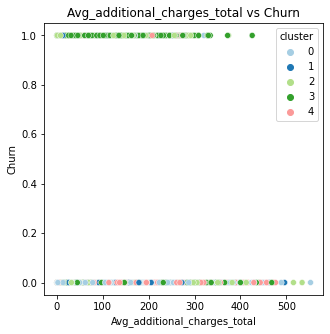

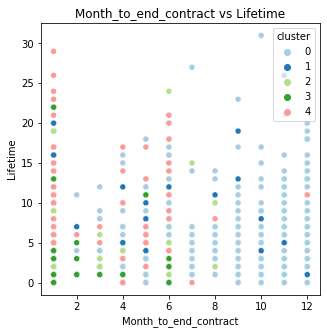

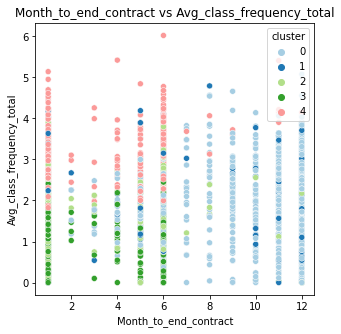

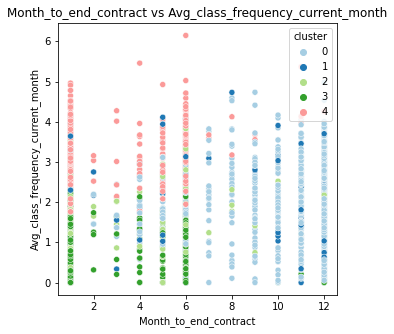

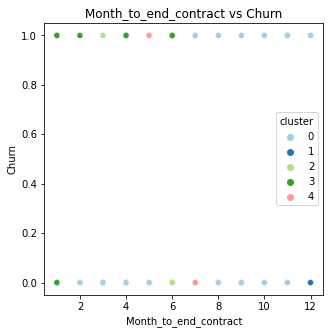

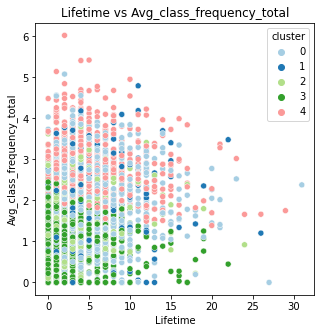

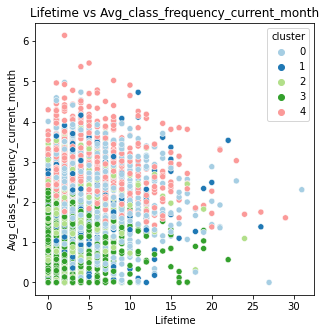

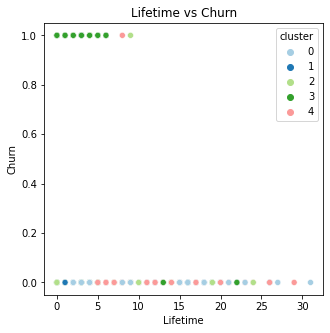

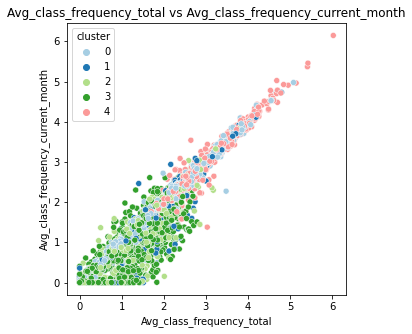

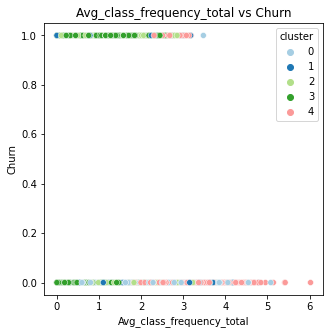

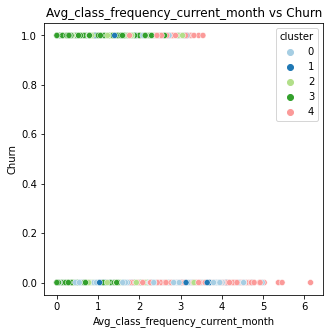

In [28]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(df.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster')

По графикам для попарных сочетаний признаков с разметкой по кластерам видно, что возраст и средняя частота посещений в неделю за все время с начала действия абонемента и в предыдущий месяц оказались пограничными признаками для кластеров, ровно как и срок до окончания текущего действующего абонемента и суммарная выручка от других услуг фитнес-центра.

### Доля оттока

Выведем отдельно долю оттока в текущем месяце для каждого кластера.

In [29]:
df.groupby('cluster')['Churn'].sum() / df.groupby('cluster')['Churn'].count()

cluster
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: Churn, dtype: float64

Больше всего склонны к оттоку 2 и 3 кластеры. 0 и 4 менее всего подвержены оттоку. Крастер под номером 1 находится по середине.

### Вывод

Перед проведением кластеризации мы привели признаки к единому масштабу методом стандартизации.
Оптимальное число кластеров 5, если взять меньше - они будут слишком крупными, если меньше - то слишком меелкими и детальными.

Затем мы обучили модель кластеризации на основании алгоритма K-Means и спрогнозировали кластеры клиентов.

Сразу бросается в глаза кластер номер 0. Его отличительные особенности:
- средний показатель по факту оттока в текущем месяце минимален (0,03)
- большая часть - это сотрудники компании-партнёра клуба
- длительность текущего действующего абонемента в среднем 11 месяцев (т.е. большинство абонементов - годовые)
- чуть больше половины посещают групповые занятия
- суммарная выручка от других услуг фитнес-центра в среднем выше, чем в других кластерах (кроме 4)
- срок до окончания текущего действующего абонемента в среднем 10 месяцев (т.е. клиенты в начале своего абонемента)
- посещают клуб около 2 раз в неделю (как до текущего месяца, так и в текущем месяце)

Противоположные ему кластер номер 3:
- средний показатель по факту оттока в текущем месяце максимален (0,51)
- проживают в районе расположения клуба
- длительность текущего действующего абонемента в среднем 2 месяца (краткосрочный абоненмент, приобретаемый для тестирования услуг клуба, на период отпуска и т.п.)
- лишь треть из клиентов ходит на групповые занятия
- суммарная выручка от других услуг фитнес-центра в среднем ниже, чем в других кластерах
- срок до окончания текущего действующего абонемента в среднем 2 месяца (т.е. клиенты в начале своего абонемента)
- посещают клуб раз в неделю, и частота посещений сокращается

По графикам для попарных сочетаний признаков с разметкой по кластерам видно, что возраст и средняя частота посещений в неделю за все время с начала действия абонемента и в предыдущий месяц оказались пограничными признаками для кластеров, ровно как и срок до окончания текущего действующего абонемента и суммарная выручка от других услуг фитнес-центра.

Вывод: больше всего склонны к оттоку 2 и 3 кластеры. 0 и 4 менее всего подвержены оттоку. Крастер под номером 1 находится по середине.

## Базовые рекомендации по работе с клиентами

1. Так как удержание тех, кто посещает групповые занятия выше --> сделать бесплатные пробные групповые занятия, либо открытые уроки.
2. Большая часть - это сотрудники компании-партнёра клуба --> увеличить количество партнеров клуба, чтобы в клуб могли прийти новые клиенты.
3. Длительность текущего действующего абонемента в среднем 11 месяцев (т.е. большинство абонементов - годовые) --> сделать скидку на годовые абонементы, либо предложить льготные условия по продлению.
4. Посещают клуб около 2 раз в неделю (как до текущего месяца, так и в текущем месяце) --> в маркетинговых акциях делать упор на регулярное посещение, возможно скидки на блоки тренировок с тренером.